In [1]:
import pandas

size_log = pandas.read_pickle("5-generated-mdps/success.pkl.gz")
aborts = pandas.read_pickle("5-generated-mdps/fail.pkl.gz")

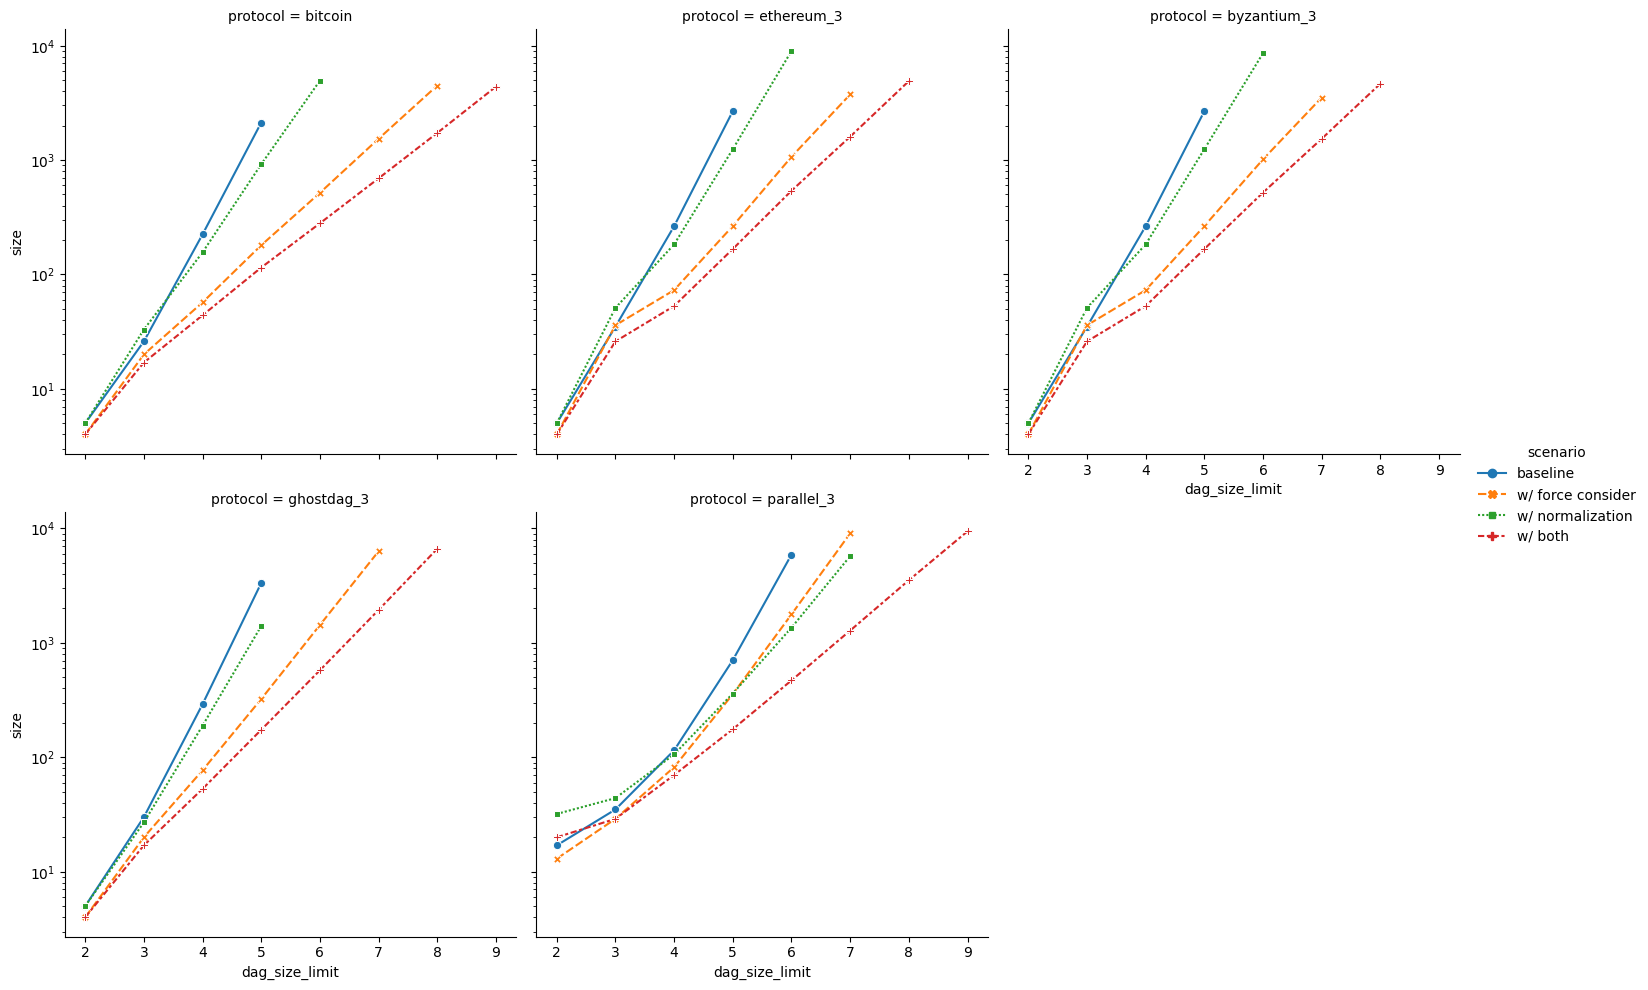

In [2]:
import seaborn

seaborn.relplot(
    data=size_log.query("dag_size_limit < 10"),
    kind="line",
    x="dag_size_limit",
    y="size",
    hue="scenario",
    style="scenario",
    markers=True,
    col="protocol",
    col_wrap=3,
).set(yscale="log")

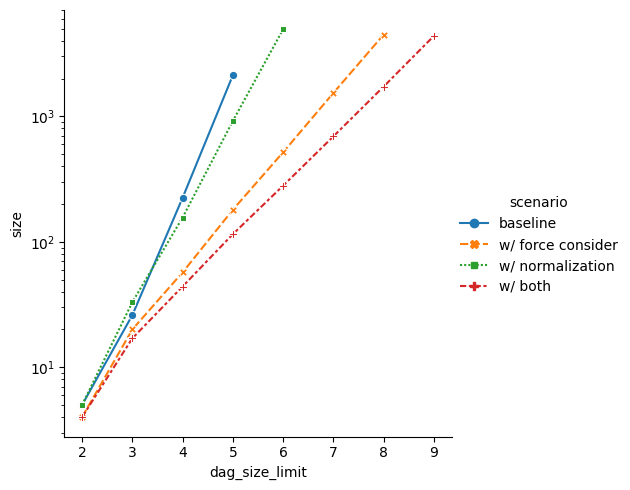

In [3]:
seaborn.relplot(
    data=size_log.query("protocol == 'bitcoin' and dag_size_limit < 13"),
    kind="line",
    x="dag_size_limit",
    y="size",
    hue="scenario",
    style="scenario",
    markers=True,
).set(yscale="log")

In [4]:
scenario_labels = {
    "reference": "reference-fc16",
    "reference-v0": "drop",
    "baseline": "baseline",
    "w/o garbage collection": "baseline-gc",
    "w/ force consider": "baseline+fc",
    "w/ normalization": "baseline+n",
    "w/ both": "baseline+fc+n",
}

cutoff = max(size_log.query("scenario != 'reference'").dag_size_limit) + 1

btc_size = (
    size_log.assign(scenario=[scenario_labels[x] for x in size_log.scenario])
    .query("scenario != 'drop'")
    .query("protocol == 'bitcoin'")
    .query(f"dag_size_limit <= {cutoff}")
    .pivot(index="dag_size_limit", columns="scenario", values="size")
)

btc_size.to_csv("5-state-space-exploration-viz-for-paper-btc-size.csv")
btc_size

scenario,baseline,baseline+fc,baseline+fc+n,baseline+n
dag_size_limit,,,,
2,5.0,4.0,4.0,5.0
3,26.0,20.0,17.0,33.0
4,224.0,57.0,44.0,156.0
5,2124.0,180.0,115.0,918.0
6,NaN,517.0,280.0,4940.0
7,NaN,1535.0,692.0,NaN
8,NaN,4476.0,1726.0,NaN
9,NaN,NaN,4378.0,NaN


In [5]:
# how should we report on the other protocols?
# column a: show max depth explored in table for fully optimized exploration only; calculate blow up factor and add as columns


def tabulate_deepest(d):
    return d.iloc[d.groupby(["scenario", "protocol"]).dag_size_limit.idxmax()]


biggest = (
    tabulate_deepest(size_log)
    .reset_index(drop=True)
    .query("scenario != 'w/o garbage collection'")
    .query("scenario != 'reference-v0'")
)

biggest.to_pickle("5-generated-mdps/biggest.pkl.gz")

biggest

,scenario,model,protocol,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,dag_size_limit,size,time_spent,rss,mdp
0,baseline,generic_1,bitcoin,False,False,True,True,False,5,2124,1.089798,0.192936,1cb6bc89
1,baseline,generic_1,byzantium_3,False,False,True,True,False,5,2673,1.792392,0.203876,7a9a4a92
2,baseline,generic_1,ethereum_3,False,False,True,True,False,5,2673,1.449414,0.200012,1c580245
3,baseline,generic_1,ghostdag_3,False,False,True,True,False,5,3338,2.094256,0.205078,284e4fa3
4,baseline,generic_1,parallel_3,False,False,True,True,False,6,5906,3.731497,0.225922,247cdffe
5,w/ both,generic_1,bitcoin,True,True,True,True,False,9,4378,5.693236,0.226482,5aa91d37
6,w/ both,generic_1,byzantium_3,True,True,True,True,False,8,4651,6.371483,0.227448,a2f67519
7,w/ both,generic_1,ethereum_3,True,True,True,True,False,8,4897,5.804419,0.227657,67644737
8,w/ both,generic_1,ghostdag_3,True,True,True,True,False,8,6643,12.095059,0.242233,3cb8faab
9,w/ both,generic_1,parallel_3,True,True,True,True,False,9,9438,12.370714,0.277100,58624ff3


In [6]:
# how should we report on the other protocols?
# column b: fix depth in table

fixed_cutoff = min(biggest.dag_size_limit)
fixed = (
    size_log.query("scenario != 'w/o garbage collection'")
    .query("scenario != 'reference-v0'")
    .query(f"dag_size_limit == {fixed_cutoff}")
    .reset_index(drop=True)
)
fixed.to_pickle("5-generated-mdps/fixed.pkl.gz")
fixed

,scenario,model,protocol,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,dag_size_limit,size,time_spent,rss,mdp
0,baseline,generic_1,bitcoin,False,False,True,True,False,5,2124,1.089798,0.192936,1cb6bc89
1,baseline,generic_1,ethereum_3,False,False,True,True,False,5,2673,1.449414,0.200012,1c580245
2,baseline,generic_1,byzantium_3,False,False,True,True,False,5,2673,1.792392,0.203876,7a9a4a92
3,baseline,generic_1,ghostdag_3,False,False,True,True,False,5,3338,2.094256,0.205078,284e4fa3
4,baseline,generic_1,parallel_3,False,False,True,True,False,5,706,0.298440,0.212681,392df4b8
5,w/ force consider,generic_1,bitcoin,True,False,True,True,False,5,180,0.077502,0.210617,10c782bc
6,w/ force consider,generic_1,ethereum_3,True,False,True,True,False,5,265,0.137281,0.214012,41fbf675
7,w/ force consider,generic_1,byzantium_3,True,False,True,True,False,5,265,0.169709,0.216423,7dc89cda
8,w/ force consider,generic_1,ghostdag_3,True,False,True,True,False,5,323,0.225399,0.214241,56507e48
9,w/ force consider,generic_1,parallel_3,True,False,True,True,False,5,356,0.133103,0.222397,3a6de90d


In [7]:
combined = pandas.DataFrame(
    dict(
        max_dag_size_limit=biggest.set_index(["scenario", "protocol"]).dag_size_limit,
        size_at_fixed_dag_size=fixed.set_index(["scenario", "protocol"])["size"],
    )
).reset_index()
combined

,scenario,protocol,max_dag_size_limit,size_at_fixed_dag_size
0,baseline,bitcoin,5,2124
1,baseline,byzantium_3,5,2673
2,baseline,ethereum_3,5,2673
3,baseline,ghostdag_3,5,3338
4,baseline,parallel_3,6,706
5,w/ both,bitcoin,9,115
6,w/ both,byzantium_3,8,167
7,w/ both,ethereum_3,8,167
8,w/ both,ghostdag_3,8,174
9,w/ both,parallel_3,9,176


In [8]:
fixed_cutoff

5

In [9]:
combined.query('scenario != "reference"').set_index(["scenario", "protocol"]).unstack(
    level=0
).stack(level=0, future_stack=True).unstack(level=1)

scenario              baseline                                   w/ both  \
            max_dag_size_limit size_at_fixed_dag_size max_dag_size_limit   
protocol                                                                   
bitcoin                      5                   2124                  9   
byzantium_3                  5                   2673                  8   
ethereum_3                   5                   2673                  8   
ghostdag_3                   5                   3338                  8   
parallel_3                   6                    706                  9   

scenario                            w/ force consider                         \
            size_at_fixed_dag_size max_dag_size_limit size_at_fixed_dag_size   
protocol                                                                       
bitcoin                        115                  8                    180   
byzantium_3                    167                  7                    265   
ethereum_3                     167                  7                    265   
ghostdag_3                     174                  7                    323   
parallel_3                     176                  7                    356   

scenario      w/ normalization                         
            max_dag_size_limit size_at_fixed_dag_size  
protocol                                               
bitcoin                      6                    918  
byzantium_3                  6                   1244  
ethereum_3                   6                   1244  
ghostdag_3                   5                   1403  
parallel_3                   7                    361